In [1]:
from lib.rendering.utils import visualize_image, visualize_normals
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
)

ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SignedDistanceFunction(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
sphere_tracer = SphereTracer(max_steps=500, warm_step_scale=0.8)
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

depth, mask = scene.render_depth() 
visualize_image(scene.to_image(depth, mask))

normals, mask = scene.render_normals()
visualize_normals(scene.to_image(normals, mask))

image, mask = scene.render_image()
visualize_image(scene.to_image(image, mask, default=1))

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


  0%|          | 0/20 [00:00<?, ?it/s]

0 tensor(101.2176, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


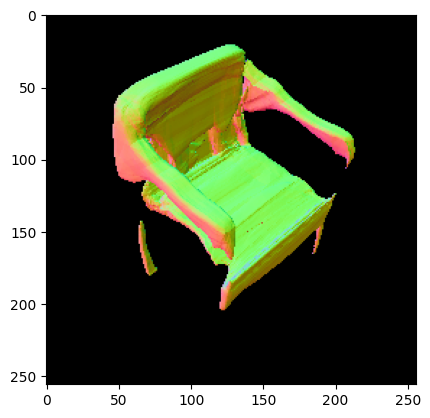

 10%|█         | 2/20 [00:01<00:09,  1.80it/s]

2 tensor(100.8824, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


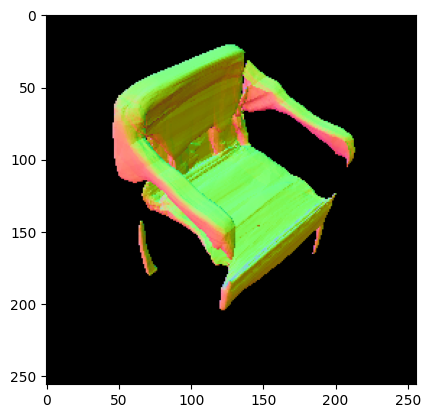

 20%|██        | 4/20 [00:02<00:08,  1.80it/s]

4 tensor(100.8771, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


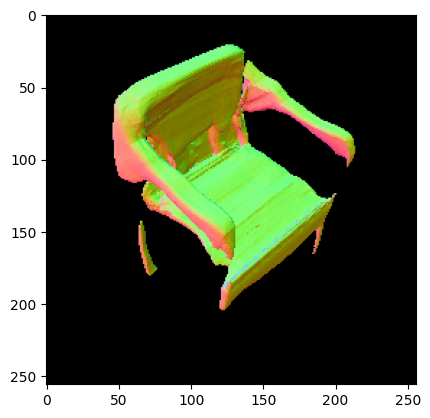

 30%|███       | 6/20 [00:03<00:07,  1.80it/s]

6 tensor(101.0801, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


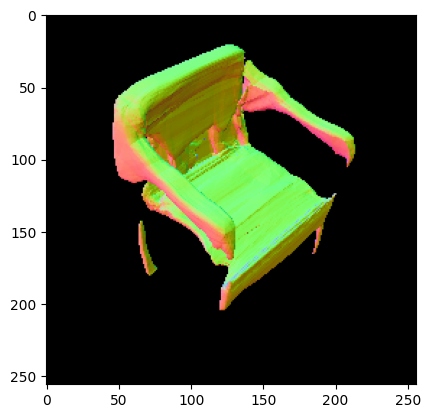

 40%|████      | 8/20 [00:04<00:06,  1.79it/s]

8 tensor(100.9710, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


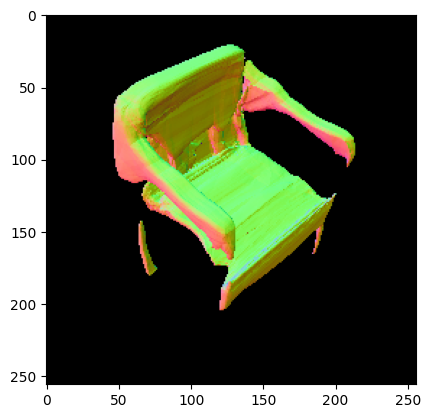

 50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

10 tensor(101.1101, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


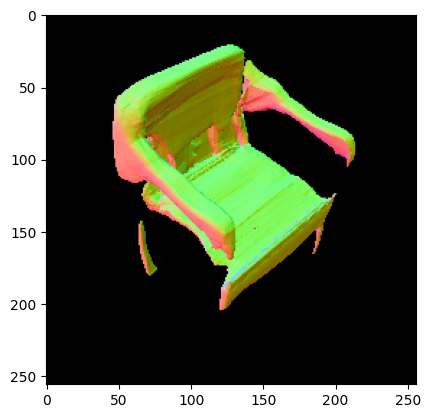

 60%|██████    | 12/20 [00:06<00:04,  1.78it/s]

12 tensor(101.1171, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


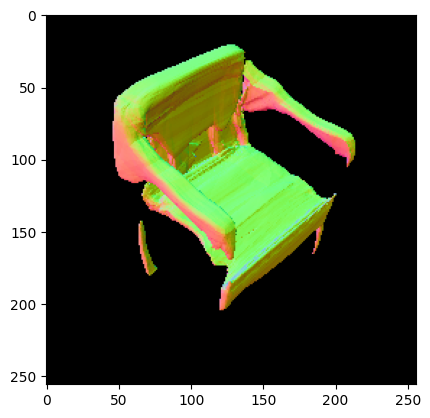

 70%|███████   | 14/20 [00:08<00:03,  1.78it/s]

14 tensor(101.1074, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


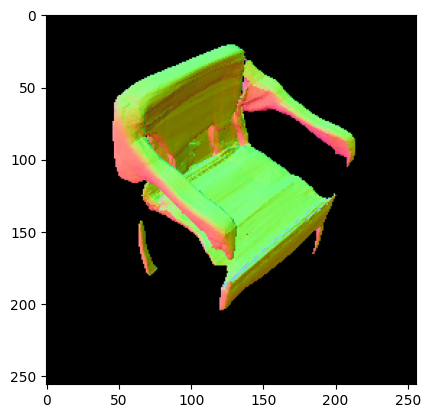

 80%|████████  | 16/20 [00:09<00:02,  1.75it/s]

16 tensor(101.1503, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


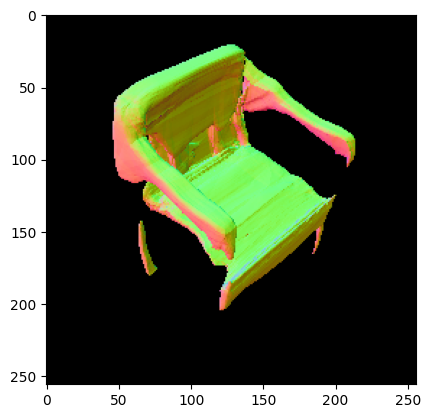

 90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

18 tensor(101.0540, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


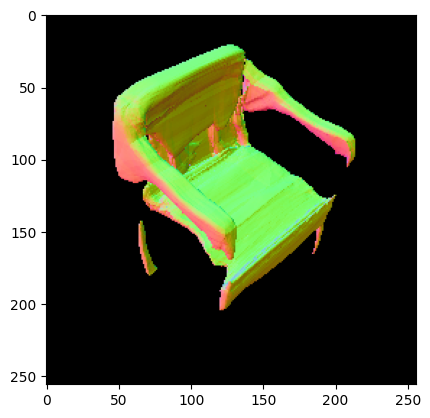

100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


In [15]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.nn.functional import normalize
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"

sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda") * 0.2
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

sdf.lat_vec.requires_grad = True
optimizer = Adam([sdf.lat_vec], lr=0.5)

for steps in tqdm(range(20)):
    optimizer.zero_grad()
    points, mask, _ = scene.sphere_tracing()
    points.requires_grad = True
    sd = sdf.predict(points, mask)
    grad, = torch.autograd.grad(
        outputs=sd, 
        inputs=points, 
        grad_outputs=torch.ones_like(sd), 
        create_graph=True,
    )
    # grad.requires_grad = True
    target_normals = normalize(grad)
    loss = torch.norm(target_normals[mask] - normals[mask])
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if steps % 2 == 0: 
        print(steps, loss)
        # print(sdf.lat_vec[0])
        visualize_normals(scene.to_image(target_normals, mask))

    # loss = sd.sum()
    # loss.backward(retain_graph=True)
    # target_normals = normalize(points.grad)  # type: ignore
    



In [14]:
points

tensor([[ 0.1733,  0.7292,  1.4796],
        [ 0.1802,  0.7248,  1.4686],
        [ 0.1870,  0.7204,  1.4577],
        ...,
        [-0.0600, -0.4592, -1.2903],
        [-0.0560, -0.4641, -1.2940],
        [-0.0521, -0.4689, -1.2977]], device='cuda:0', requires_grad=True)

In [13]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
sketch_path = "/home/borth/sketch2shape/data/siamese_chair_large/96d9944f46bd330979414e04132a8bef/sketches/00021.jpg"

# siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
# sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda")
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)

optimizer = Adam(sdf.model.parameters(), lr=1e-04)
normals.requires_grad = True

for steps in tqdm(range(100)):
    # image_emb = siamese.decoder(image[None])
    # normalized_image_emb = torch.nn.functional.normalize(image_emb)
    # loss = (sketch_emb @ image_emb.T).sum()
    target_normals, mask = scene.render_normals()
    
    loss = torch.norm(target_normals[mask] - normals[mask])
    loss.backward(retain_graph=True)

    if steps % 10 == 0: 
        print(steps, loss)
        visualize_normals(target_normals) 

    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

torch.Size([196608, 1])

In [58]:
from lib.utils import load_config
from lightning import Trainer
from lib.eval.tester import SiameseTester
import hydra

cfg = load_config("eval_siamese", overrides=["+experiment=eval"])
tester = SiameseTester(model=siamese.decoder)
datamodule = hydra.utils.instantiate(cfg.data, train=False)
datamodule.setup("all")
trainer = Trainer(
    accelerator="gpu",
    max_epochs=1,
    enable_checkpointing=False,
)
trainer.validate(
    tester,
    dataloaders=[
        datamodule.train_dataloader(),
        datamodule.val_dataloader(),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/borth/sketch2shape/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{}, {}]